In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model
from ruptures import Pelt
import warnings
warnings.filterwarnings('ignore')

In [21]:
import pandas as pd
import glob

# Get a list of all XLSX files in the current directory
file_list = glob.glob('../data/*.xlsx')

# Create an empty list to store DataFrames
df_list = []

# Check if there are any XLSX files found
if not file_list:
  print("No XLSX files found in the current directory.")
else:
  # Read each XLSX file into a DataFrame and append to the list (if not empty)
  for file in file_list:
      try:
          df = pd.read_excel(file)
          df_list.append(df)
      except FileNotFoundError:
          print(f"File not found: {file}")

# Only proceed with concatenation if there are DataFrames in the list
if df_list:
  # Concatenate all DataFrames into a single DataFrame
  df = pd.concat(df_list, ignore_index=True)

display(df.head())

,Trade Date,Symbol,Warehouse,Production Year,Opening Price,Closing Price,High,Low,Change,Persetntage Change,Volume (Ton)
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-02,WYKQ2,BG,2004.0,"1,175.00",0.00,"1,175.00","1,175.00",0.0,0.0,28.29
3,2012-01-03,WYKQ2,BG,2004.0,"1,175.00",0.00,"1,175.00","1,175.00",0.0,0.0,10.80
4,2012-01-04,WYKQ2,BG,2004.0,"1,180.00",0.00,"1,180.00","1,180.00",0.0,0.0,6.61


In [22]:
display(df.columns)
display(df.info())

Index(['Trade Date', 'Symbol', 'Warehouse', 'Production Year', 'Opening Price',
       'Closing Price', 'High', 'Low', 'Change', 'Persetntage Change',
       'Volume (Ton)'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91439 entries, 0 to 91438
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Trade Date          91423 non-null  datetime64[ns]
 1   Symbol              91423 non-null  object        
 2   Warehouse           91423 non-null  object        
 3   Production Year     91423 non-null  float64       
 4   Opening Price       91423 non-null  object        
 5   Closing Price       91423 non-null  object        
 6   High                91423 non-null  object        
 7   Low                 91423 non-null  object        
 8   Change              91423 non-null  float64       
 9   Persetntage Change  91423 non-null  object        
 10  Volume (Ton)        91423 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(7)
memory usage: 7.7+ MB


None

In [23]:
display(df.describe())

,Trade Date,Production Year,Change,Volume (Ton)
count,91423,91423.000000,91423.000000,91423.000000
mean,2016-01-27 10:51:25.691784448,2007.398106,24.979907,22.745432
min,2012-01-02 00:00:00,2002.000000,0.000000,1.800000
25%,2014-02-19 00:00:00,2005.000000,0.000000,6.830000
50%,2016-02-29 00:00:00,2007.000000,10.000000,12.750000
75%,2018-02-13 00:00:00,2009.000000,29.000000,25.500000
max,2019-09-13 00:00:00,2011.000000,2230.000000,596.700000
std,NaN,2.366144,58.014626,29.990070


In [24]:
# Reset the index to make 'Date' a column again
df.reset_index(inplace=True)

# Convert columns to float where possible
for column in df.columns:
    try:
        df[column] = df[column].str.replace(',', '').astype(float)
    except (ValueError, AttributeError):
        continue

# Convert 'Trade Date' to datetime and clean the data
df['Trade Date'] = pd.to_datetime(df['Trade Date'], errors='coerce')
df = df.dropna(subset=['Trade Date'])
df = df.sort_values(by='Trade Date')
df = df.rename(columns={'Trade Date': 'Date'})
df.reset_index(drop=True, inplace=True)

# Ensure there are no missing values
df = df.dropna()

# Set 'Date' as the index again
df.set_index('Date', inplace=True)


In [25]:
display(df.head())
display(df.tail())

,index,Symbol,Warehouse,Production Year,Opening Price,Closing Price,High,Low,Change,Persetntage Change,Volume (Ton)
Date,,,,,,,,,,,
2012-01-02,2,WYKQ2,BG,2004.0,1175.0,0.0,1175.0,1175.0,0.0,0.0,28.29
2012-01-02,1340,WSDA3,HW,2004.0,1380.0,0.0,1380.0,1375.0,0.0,0.0,48.60
2012-01-02,3658,ULK6,GM,2003.0,1270.0,0.0,1270.0,1270.0,0.0,0.0,17.85
2012-01-02,1565,WLMAQ2,JM,2004.0,1250.0,0.0,1250.0,1250.0,0.0,0.0,10.80
2012-01-02,881,WSDB3,DL,2004.0,1300.0,0.0,1305.0,1300.0,0.0,0.0,21.61


,index,Symbol,Warehouse,Production Year,Opening Price,Closing Price,High,Low,Change,Persetntage Change,Volume (Ton)
Date,,,,,,,,,,,
2019-09-13,86791,UHRA4,DD,2011.0,2480.0,2480.0,2480.0,2480.0,0.0,0.0%,10.20
2019-09-13,86507,UHRB4,DD,2011.0,2200.0,2200.0,2200.0,2200.0,15.0,0.0%,5.10
2019-09-13,88038,UGJ3,HW,2011.0,1575.0,1575.0,1575.0,1575.0,25.0,1.0%,5.10
2019-09-13,82269,WGM3,GM,2011.0,1061.0,1061.0,1061.0,1061.0,0.0,0.0,8.01
2019-09-13,90273,LWBP2,SC,2010.0,1353.0,1353.0,1353.0,1353.0,5.0,0.0%,10.20


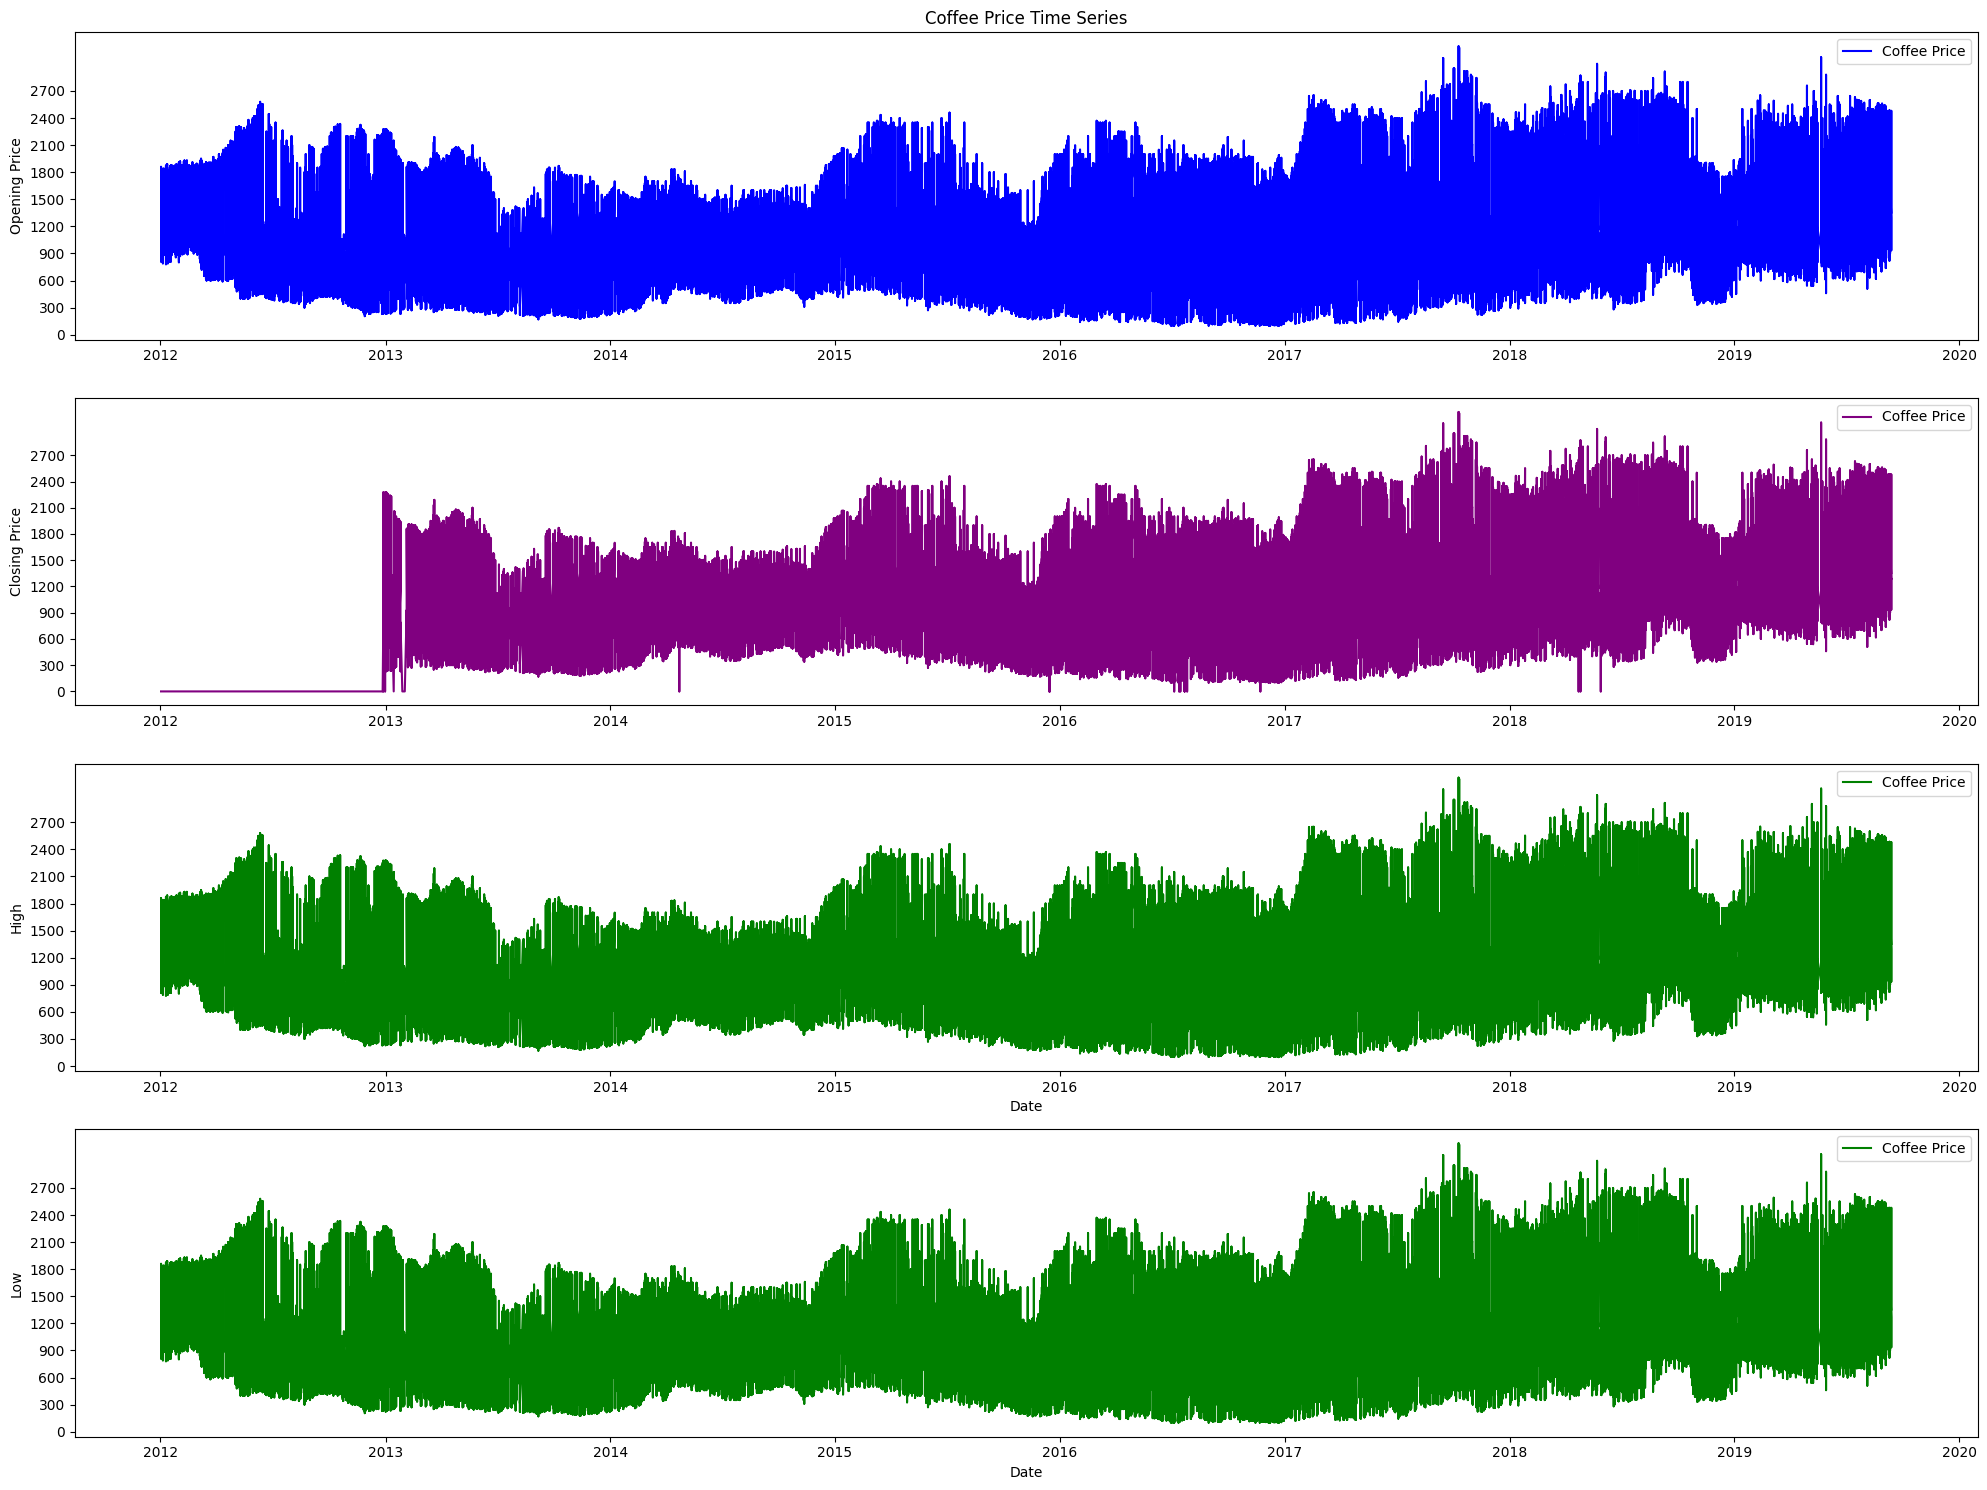

In [26]:
import matplotlib.pyplot as plt
import numpy as np
def plot_time_series(df):
    
    plt.figure(figsize=(20, 15))
    
    # Plot Price
    plt.subplot(4, 1, 1)
    plt.yticks(np.arange(0, 3000, step=300))
    plt.plot(df.index, df['Opening Price'], color='blue', label='Coffee Price')
    plt.title("Coffee Price Time Series")
    plt.ylabel("Opening Price")
    plt.legend()

    # Plot Closing price
    plt.subplot(4, 1, 2)
    plt.yticks(np.arange(0, 3000, step=300))
    plt.plot(df.index, df['Closing Price'], color='purple', label='Coffee Price')
    plt.ylabel("Closing Price")
    plt.legend()
    
    # Plot High
    plt.subplot(4, 1, 3)
    plt.yticks(np.arange(0, 3000, step=300))
    plt.plot(df.index, df['High'], color='green', label='Coffee Price')
    plt.xlabel("Date")
    plt.ylabel("High")
    plt.legend()

        # Plot Low
    plt.subplot(4, 1, 4)
    plt.yticks(np.arange(0, 3000, step=300))
    plt.plot(df.index, df['Low'], color='green', label='Coffee Price')
    plt.xlabel("Date")
    plt.ylabel("Low")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
 
plot_time_series(df)

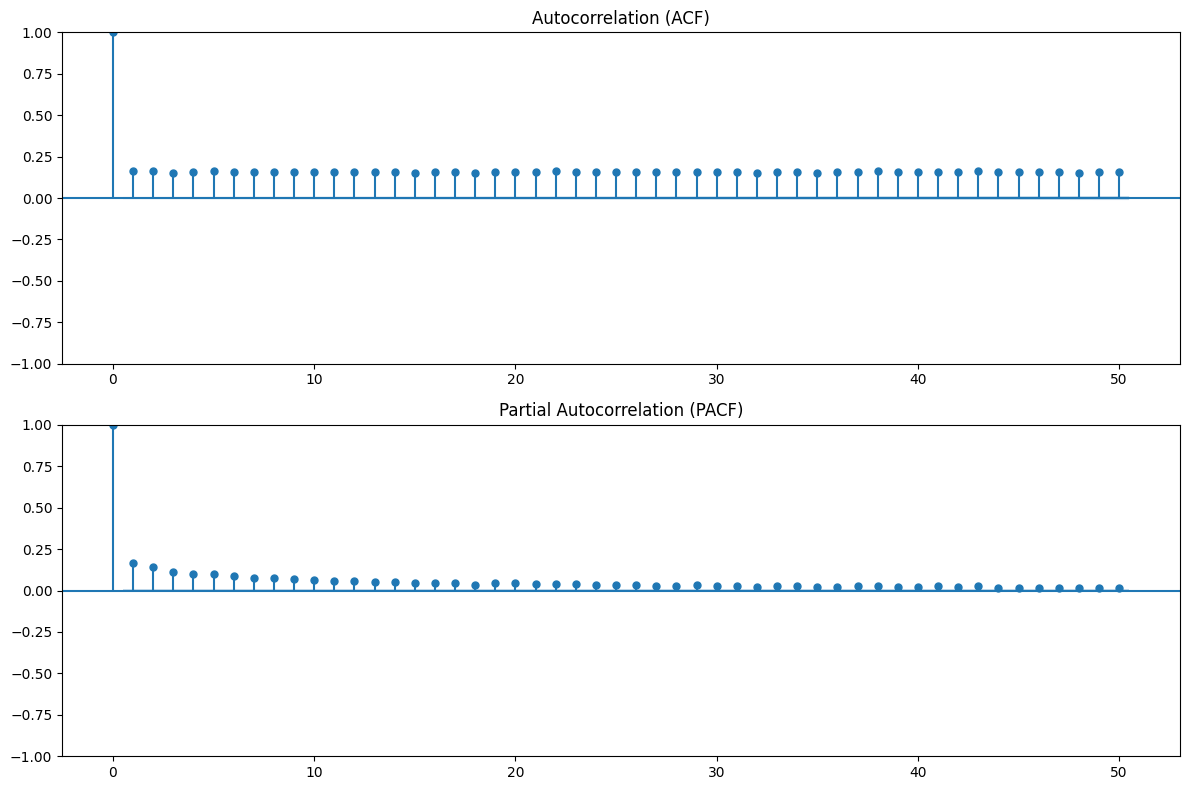

In [27]:
def plot_acf_pacf(df, column='Opening Price'):
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(df[column], ax=ax[0])
    plot_pacf(df[column], ax=ax[1])
    ax[0].set_title("Autocorrelation (ACF)")
    ax[1].set_title("Partial Autocorrelation (PACF)")
    plt.tight_layout()
    plt.show()





plot_acf_pacf(df)

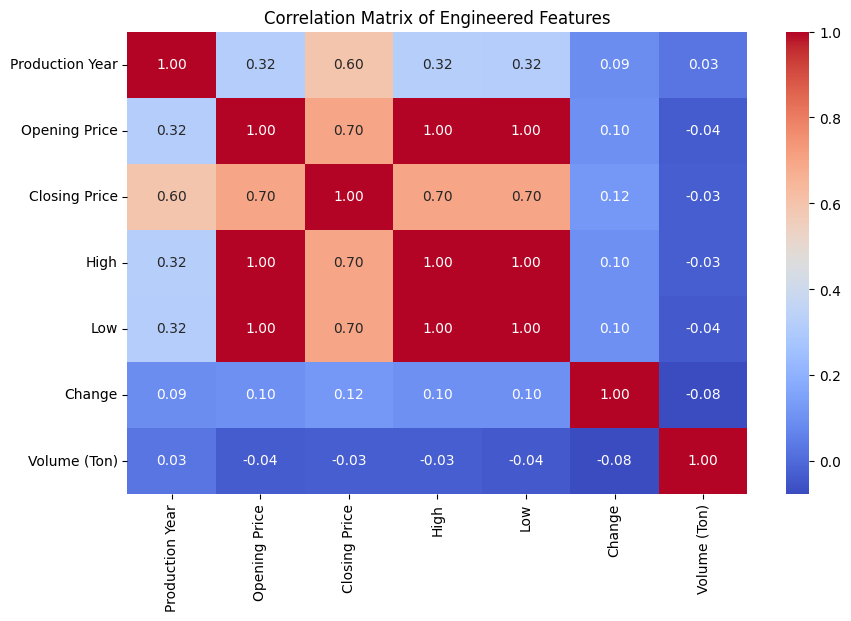

In [29]:
def correlation_analysis(df):
    # Select only float columns
    float_df = df.select_dtypes(include=['float64'])
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(float_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Engineered Features")
    plt.show()

correlation_analysis(df)

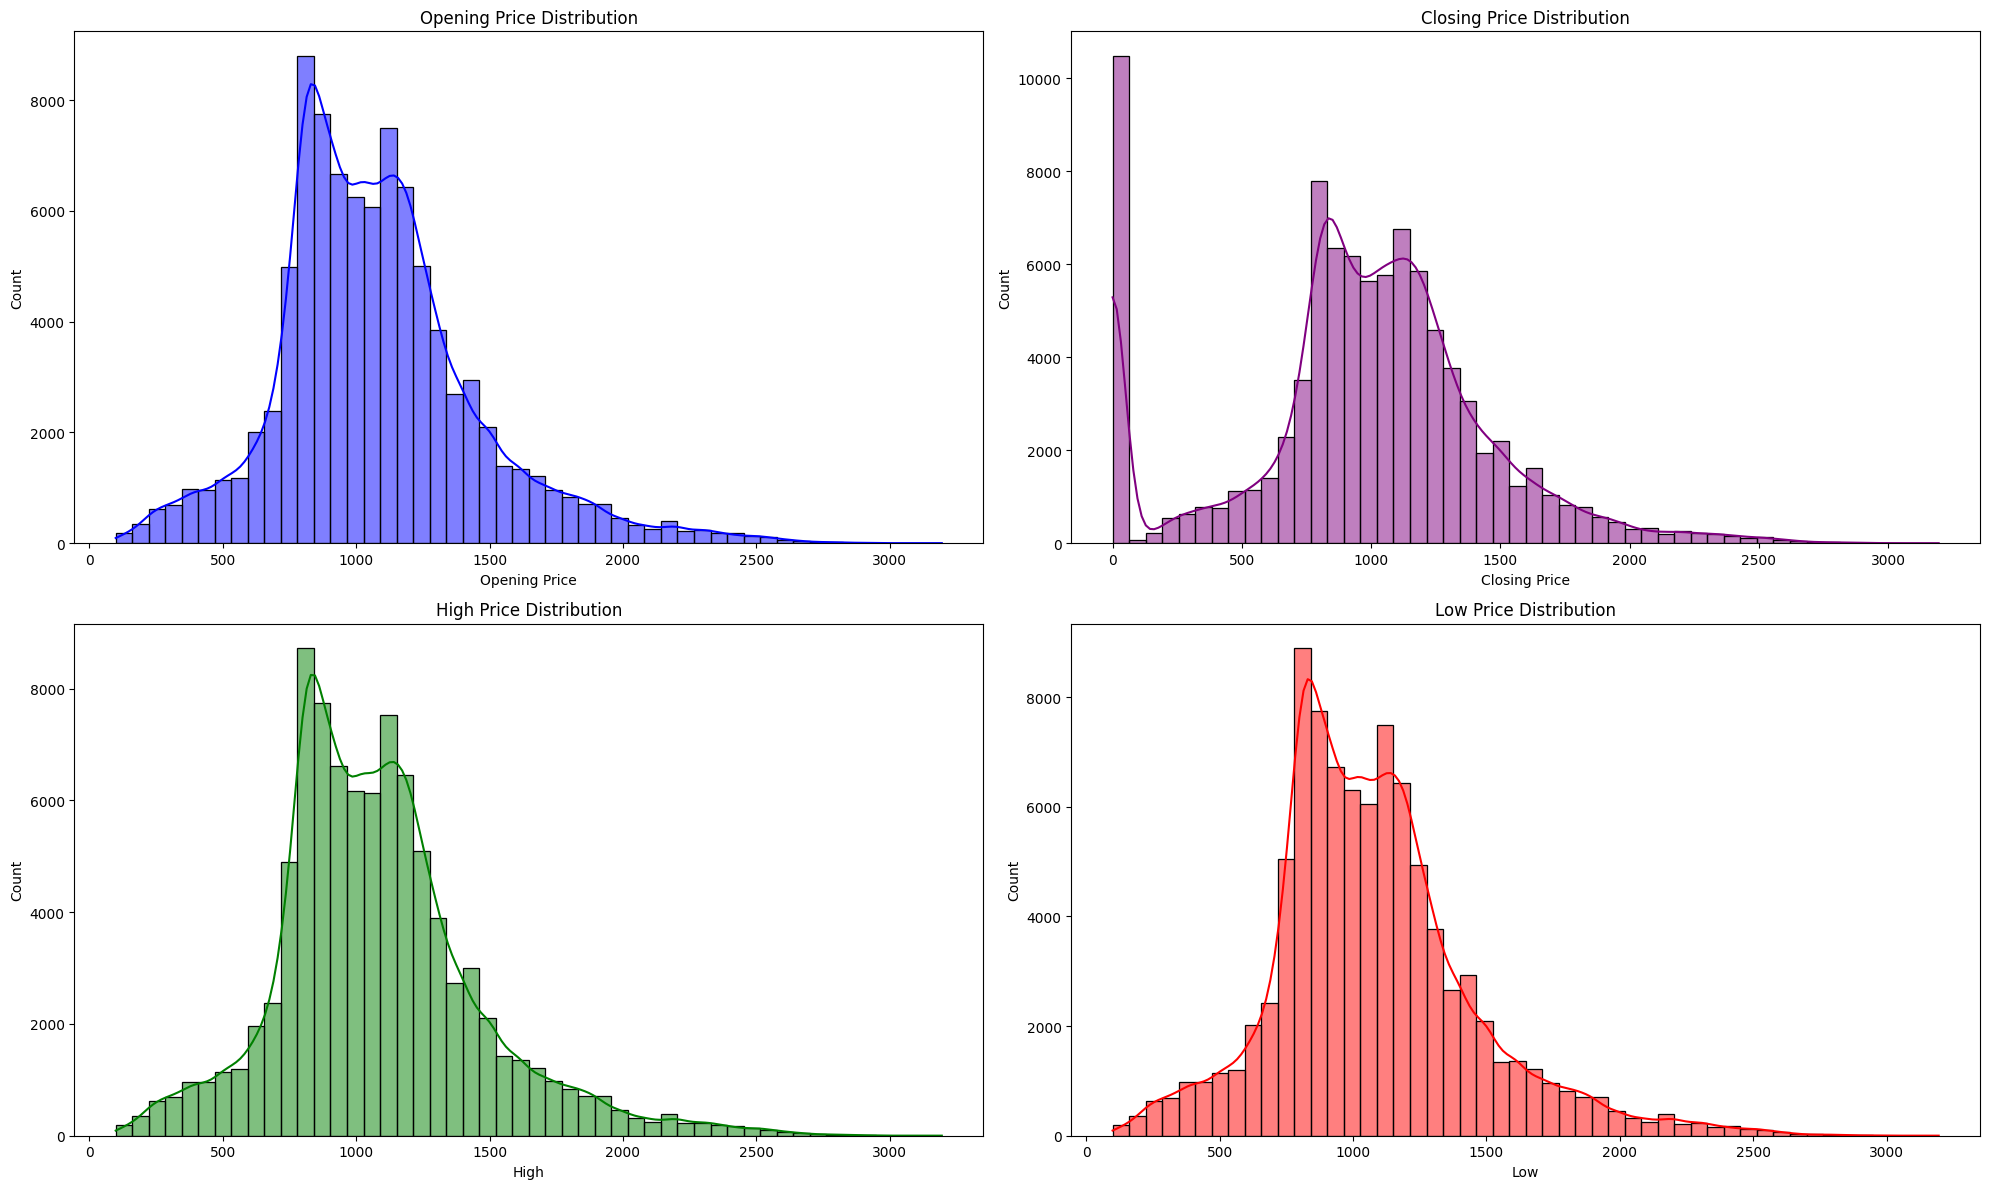

In [30]:
# Distribution Analysis
def distribution_analysis(df):
    
    plt.figure(figsize=(20, 12))
    
    # Opening Price Distribution
    plt.subplot(2, 2, 1)
    sns.histplot(df['Opening Price'], bins=50, color='blue', kde=True)
    plt.title("Opening Price Distribution")

    # Closing Price Distribution
    plt.subplot(2, 2, 2)
    sns.histplot(df['Closing Price'], bins=50, color='purple', kde=True)
    plt.title("Closing Price Distribution")
    
    # High Price Distribution
    plt.subplot(2, 2, 3)
    sns.histplot(df['High'], bins=50, color='green', kde=True)
    plt.title("High Price Distribution")
    
    # Low Price Distribution
    plt.subplot(2, 2, 4)
    sns.histplot(df['Low'], bins=50, color='red', kde=True)
    plt.title("Low Price Distribution")
    
    plt.tight_layout()
    plt.show()

distribution_analysis(df)

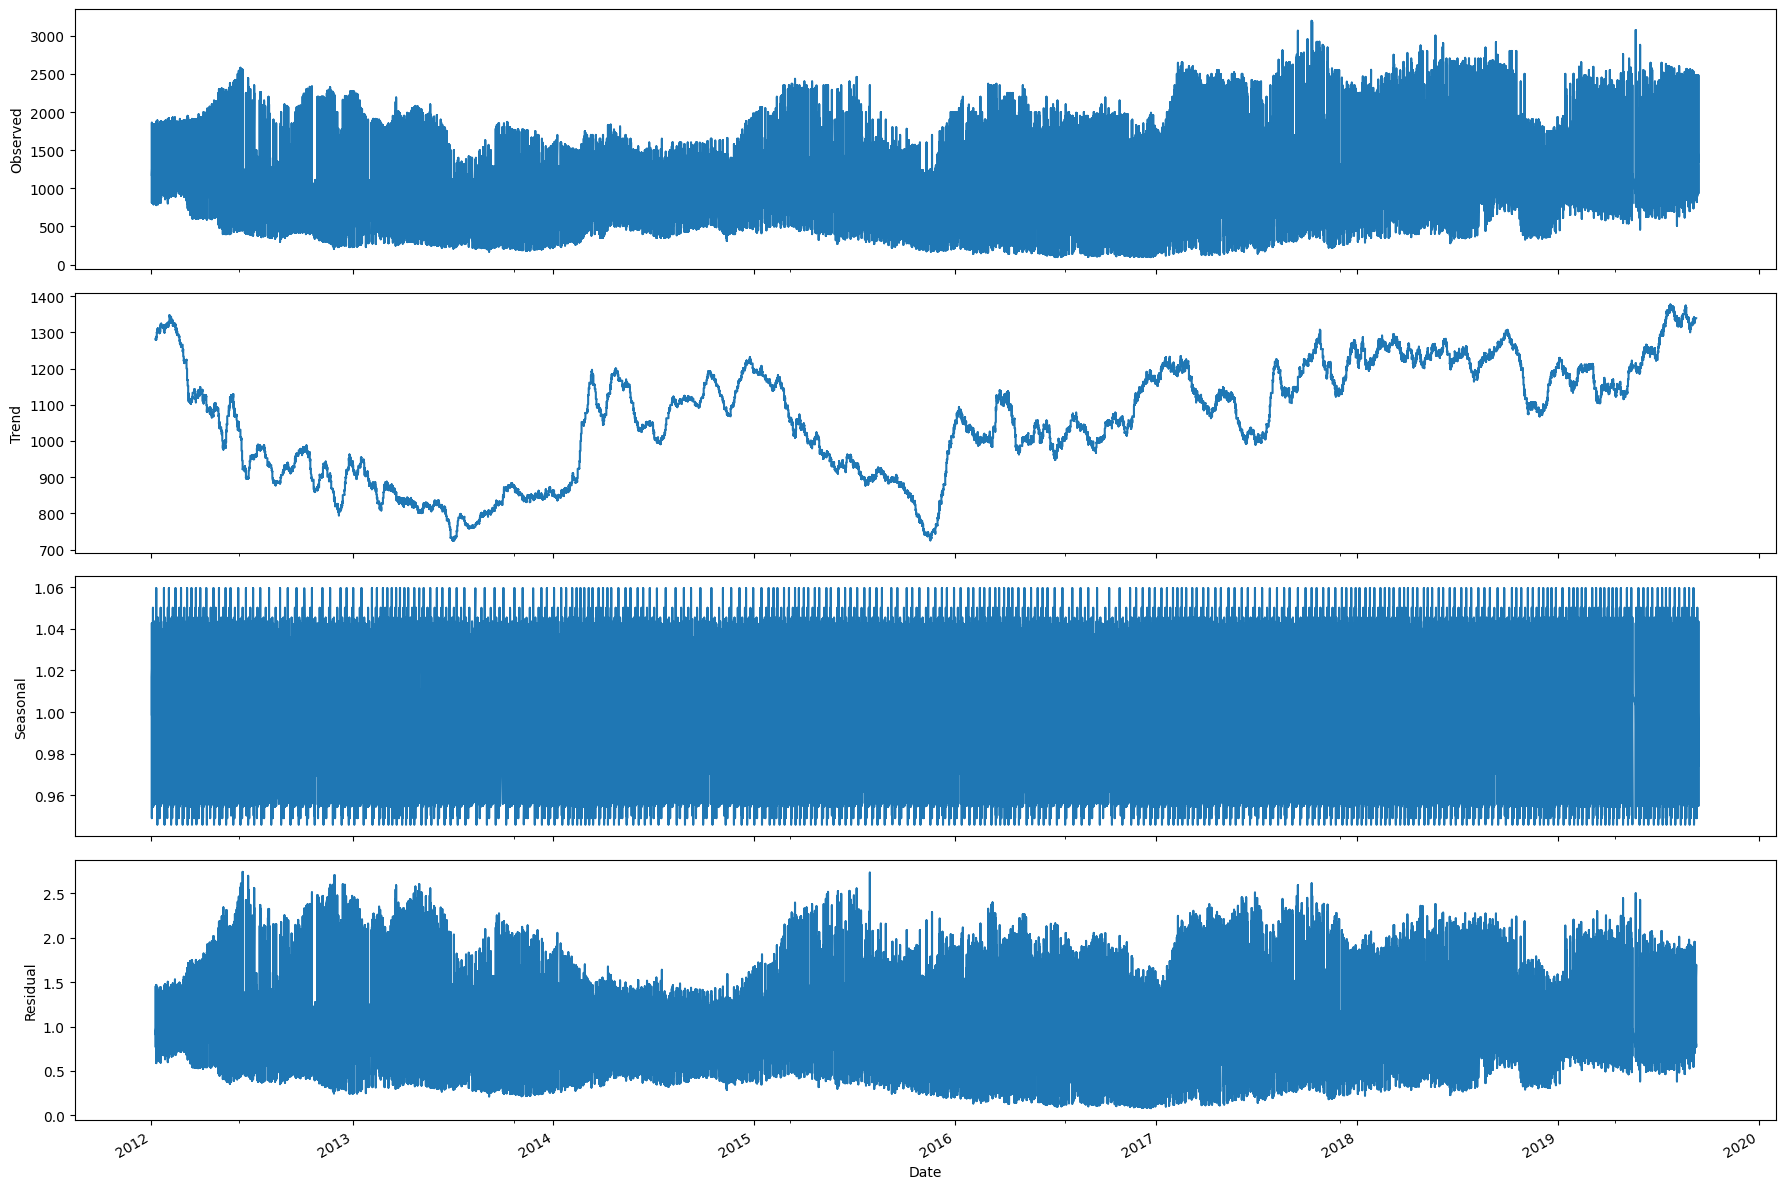

In [31]:
# Seasonality Analysis
def seasonality_analysis(df):
   
    decomposition = seasonal_decompose(df['Opening Price'], model='multiplicative', period=365)

    # Set up a wider figure
    fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)
    
    # Plot each component with wider axes
    decomposition.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    
    decomposition.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')
    
    plt.tight_layout()
    plt.show()

seasonality_analysis(df)

In [32]:
# Calculate Returns
df['Returns'] = df['Closing Price'].pct_change()

# Risk Metrics Calculation
def calculate_risk_metrics(df, confidence_level=0.05):
    var = np.percentile(df['Returns'].dropna(), 100 * confidence_level)
    es = df['Returns'][df['Returns'] <= var].mean()
    
    print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {var:.4f}")
    print(f"Expected Shortfall (ES) at {confidence_level*100}% confidence level: {es:.4f}")

calculate_risk_metrics(df)

Value at Risk (VaR) at 5.0% confidence level: -0.5660
Expected Shortfall (ES) at 5.0% confidence level: -0.6815
